In [1]:
!pip3 install tensorflow==2.10.0 numpy==1.22

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 241.2/241.2 MB 3.1 MB/s eta 0:00:0000:0100:02
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.7/17.7 MB 5.1 MB/s eta 0:00:0000:0100:01
  Using cached gast-0.4.0-py3-none-any.whl (9.8 kB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.2/12.2 MB 37.0 MB/s eta 0:00:00a 0:00:01
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.5/3.5 MB 46.5 MB/s eta 0:00:00a 0:00:01
  Using cached google_pasta-0.2.0-py3-none-any.whl (57 kB)
  Using cached protobuf-3.19.6-py2.py3-none-any.whl (162 kB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 43.8 MB/s eta 0:00:0000:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 438.7/438.7 kB 22.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 133.7/133.7 kB 35.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.9/5.9 MB 46.1 MB/s eta 0:00:0000:0100:01
  Using cached astunparse-1.6.3-py2.py3-none-any.whl (12 kB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [2]:
import tensorflow as tf
print("TensorFlow version:", tf.__version__)

# from tensorflow.keras.layers import Dense
# from tensorflow.keras import Model
# from tensorflow.keras import layers
# from tensorflow import keras
# import os
# import sys
# import matplotlib.pyplot as plt
# import pandas as pd
# import seaborn as sns
# import csv
# import pickle
# from scipy.stats import linregress
# from sklearn.model_selection import train_test_split
# from datetime import datetime
# import numpy as np # type: ignore
# print("Numpy version:", np.__version__)
# from sklearn.preprocessing import Normalizer
# # from get_dataset import datasets
# from sklearn.svm import SVR
# from sklearn.ensemble import BaggingRegressor
# from sklearn.datasets import make_regression

# sys.path.append("..")
# sys.path.append("../analyze")
# sys.path.append("../measuring_volume")
# sys.path.append("../common")
# import pickle
# from classify_seq import make_input_seq as mis

# import keras_tuner as kt

# type_of_l = "L1"

## Loading a dataset

## Split into train data and test data as dataset

データセットからx, yを作成する

In [25]:
# [0, 1, ... 0] + temperature + eigenvalue
f1 = open("../dataset/x_initial_L1.pkl", "rb")
f2 = open("../dataset/L1_data_initial.pkl", "rb")
f_x2=["../dataset/x_QD_1_L1.pkl"]
f_y2=["../dataset/L1_data_QD_1.pkl"]
domain_seq_dic = pickle.load(f1)
value_dic = pickle.load(f2)
for fx in f_x2:
    fx = open(fx, "rb")
    domain_seq_dic.update(pickle.load(fx))
for fy in f_y2:
    fy = open(fy, "rb")
    value_dic.update(pickle.load(fy))
domain_lst = mis.seq_lst(f"../conf/input_seq_{type_of_l}.csv")

f1.close()
f2.close()

x_data = []
y_data = []

for key in domain_seq_dic:
    new_x = []
    for domain in domain_lst:
        new_x.append(domain_seq_dic[key]["domain"][domain])
    new_x.append(int(key[0]))
    new_x.append(float(domain_seq_dic[key]['eigenValue_2']))
    x_data.append(new_x)
    y_data.append(value_dic[key]['mean_volume'])

print(x_data)
print(y_data)



ModuleNotFoundError: No module named 'numpy._core'

In [86]:
x_data = np.array(x_data)
y_data = np.array(y_data)

# x_train, x_test, y_train, y_test = train_test_split(x_data, y_data, test_size=0.2)
x_train, x_test, y_train, y_test = train_test_split(x_data, y_data, test_size=0.2, random_state=1)

print(len(x_train))


480


## Set my model
- input_shape は入力データのサイズ。
- モデルの定義方法は調べればたくさん出てきますが、例えばここ： https://sinyblog.com/deaplearning/keras_how_to/ 
- 最後の層の出力は、期待する出力データのサイズ
- [model](https://github.com/si-tm/docs-l10n/blob/master/site/ja/tutorials/quickstart/beginner.py)

In [87]:
def build_model():
    
    # model = tf.keras.models.Sequential([
    # tf.keras.layers.Flatten(input_shape=(x_train.shape[1],)),
    # tf.keras.layers.Dense(128, activation='relu'), # units=128 : 出力空間の次元数
    # tf.keras.layers.Dropout(0.2), # 入力にドロップアウトを適用する rate=0.2 : 入力ユニットをドロップする割合
    # tf.keras.layers.Dense(1) 
    # ])

    model = tf.keras.models.Sequential([
    tf.keras.layers.Flatten(input_shape=(x_train.shape[1],)),
    tf.keras.layers.Dense(128, activation='relu', name="layer1"), # units=128 : 出力空間の次元数
    tf.keras.layers.Dense(128, activation='relu', name="layer2"), # units=128 : 出力空間の次元数 # units=128 : 出力空間の次元数
    # tf.keras.layers.Dense(128, activation='relu', name="layer3"), # units=128 : 出力空間の次元数
    # tf.keras.layers.Dense(128, activation='relu', name="layer4"), # units=128 : 出力空間の次元数 # units=128 : 出力空間の次元数
    # tf.keras.layers.Dense(128, activation='relu', name="layer5"), # units=128 : 出力空間の次元数 # units=128 : 出力空間の次元数
    tf.keras.layers.Dropout(0.2), # 入力にドロップアウトを適用する rate=0.2 : 入力ユニットをドロップする割合
    tf.keras.layers.Dense(1) 
    ])

    optimizer = tf.keras.optimizers.Adam() # optimizers も Adam 以外に色々種類があります。調べてみてください！

    model.compile(loss='mse',
                optimizer=optimizer,
                metrics=['mae', 'mse']) # loss 関数に何を採用するかはどんな問題を解きたいのかによります。
                                        #ここでは MSE を採用していますが、他にも色々な選択肢があります。調べてみてください！
    return model

In [88]:
model = build_model()

In [89]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_2 (Flatten)         (None, 18)                0         
                                                                 
 layer1 (Dense)              (None, 128)               2432      
                                                                 
 layer2 (Dense)              (None, 128)               16512     
                                                                 
 dropout_2 (Dropout)         (None, 128)               0         
                                                                 
 dense_2 (Dense)             (None, 1)                 129       
                                                                 
Total params: 19,073
Trainable params: 19,073
Non-trainable params: 0
_________________________________________________________________


In [90]:
example_batch = x_train[:10]
print(example_batch.shape)
example_result = model.predict(example_batch)
# example_result

(10, 18)
1/1 [==============================] - 0s 39ms/step


In [91]:
print(example_result)

[[18.48121 ]
 [16.022701]
 [20.036833]
 [20.694532]
 [17.738388]
 [20.117823]
 [18.975054]
 [19.367067]
 [18.864021]
 [20.610924]]


In [92]:
# エポックが終わるごとにドットを一つ出力することで進捗を表示
class PrintDot(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs):
        if epoch % 100 == 0: print('')
        print('.', end='')

# early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)
EPOCHS = 100 # epoch 数も考慮しよう
# EPOCHS = 100 # epoch 数も考慮しよう

history = model.fit(
    x_train, y_train,
    epochs=EPOCHS, validation_split = 0.2, verbose=0,
    callbacks=[PrintDot()]
)


....................................................................................................

In [93]:
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.tail()

,loss,mae,mse,val_loss,val_mae,val_mse,epoch
95,22.566309,2.900737,22.566309,24.782831,2.408631,24.782831,95
96,23.019781,2.864296,23.019781,25.842979,2.368993,25.842979,96
97,23.733713,2.954057,23.733713,25.672974,2.363212,25.672974,97
98,21.990705,2.872007,21.990705,24.024643,3.089373,24.024643,98
99,22.701143,2.930866,22.701143,23.720591,2.735377,23.720591,99


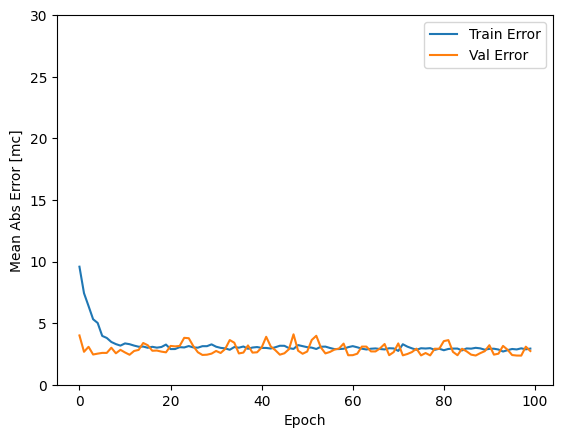

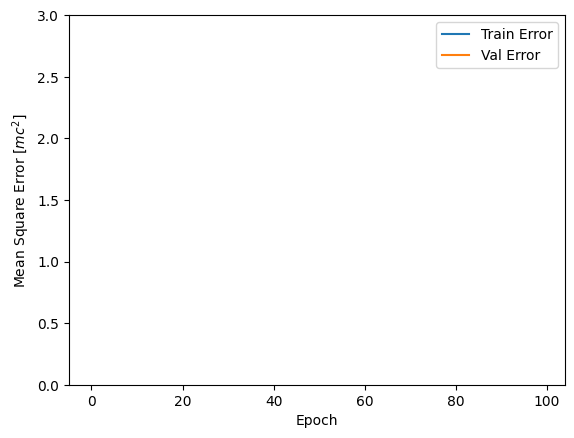

In [94]:
def plot_history(history):
    hist = pd.DataFrame(history.history)
    hist['epoch'] = history.epoch

    plt.figure()
    plt.xlabel('Epoch')
    plt.ylabel('Mean Abs Error [mc]')
    plt.plot(hist['epoch'], hist['mae'], label='Train Error')
    plt.plot(hist['epoch'], hist['val_mae'], label = 'Val Error')
    plt.ylim([0,30])
    plt.legend()

    plt.figure()
    plt.xlabel('Epoch')
    plt.ylabel('Mean Square Error [$mc^2$]')
    plt.plot(hist['epoch'], hist['mse'], label='Train Error')
    plt.plot(hist['epoch'], hist['val_mse'], label = 'Val Error')
    plt.ylim([0,3])
    plt.legend()
    plt.show()


plot_history(history)

4/4 [==============================] - 0s 918us/step


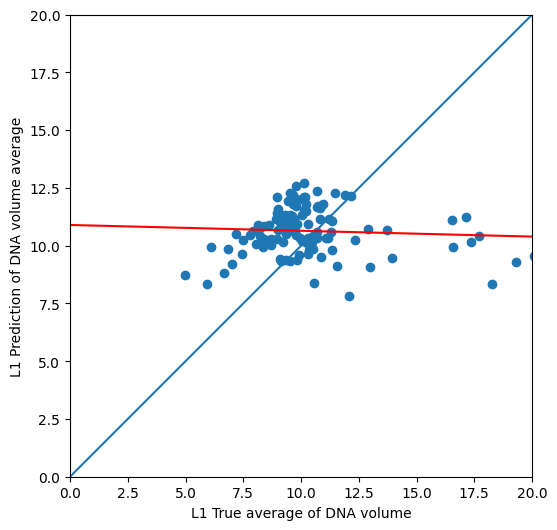

In [95]:
test_predictions = model.predict(x_test).flatten()
res = linregress(y_test, test_predictions)

plt.figure(figsize=(6,6))
plt.scatter(y_test, test_predictions)
# plt.xlabel('True Values [mc]')
# plt.ylabel('Predictions [mc]')
plt.xlabel('L1 True average of DNA volume')
plt.ylabel('L1 Prediction of DNA volume average')
plt.axis('equal')
plt.axis('square')
plt.xlim([0,20])
plt.ylim([0,20])
_ = plt.plot([0,20], [0,20])

plt.plot([0,20], res.intercept + res.slope*np.array([0, 20]), 'r', label='fitted line')

# normalizer 学習前

In [96]:
# トレーニングした model をどこかで使用したいなら以下のようにモデルを保存する
model.save('../saved_model/L1_initial_eigen')

INFO:tensorflow:Assets written to: ../saved_model/L1_initial_eigen/assets


In [97]:
from keras.models import load_model

def getModel(path="../saved_model/l1_ave_230710"):
    model = load_model(path)
    return model


In [98]:
mse = tf.keras.losses.MeanSquaredError()

In [99]:
# model = getModel()
model = getModel('../saved_model/L1_initial')
test_predictions = model.predict(x_test).flatten()

mse(y_test,test_predictions).numpy()

OSError: No file or directory found at ../saved_model/L1_initial

In [ ]:
from keras.models import load_model

def getModel(path="../saved_model/L1_initial"):
    model = load_model(path)
    return model
mse = tf.keras.losses.MeanSquaredError()
model = getModel()
test_predictions = model.predict(x_test).flatten()

mse(y_test,test_predictions).numpy()

OSError: No file or directory found at ../saved_model/L1_initial

In [111]:
from sklearn.datasets import load_diabetes, make_regression
from sklearn.model_selection import train_test_split
from sklearn.ensemble import ExtraTreesRegressor, RandomForestRegressor, GradientBoostingRegressor, StackingRegressor, VotingRegressor
from sklearn.linear_model import RidgeCV, LinearRegression
from sklearn.svm import LinearSVR
from sklearn.ensemble import RandomForestRegressor, HistGradientBoostingRegressor
import numpy as np
from sklearn.neighbors import KNeighborsRegressor
from tensorflow import keras 
import tensorflow as tf
import pandas as pd
from matplotlib.backends.backend_pdf import PdfPages

In [112]:
# https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestRegressor.html#sklearn.ensemble.RandomForestRegressor
def randomforest_regressor(x, y, x_train, x_test, y_train, y_test):
    regr = RandomForestRegressor(max_depth=2, random_state=0)
    regr.fit(x_train, y_train)
    return regr.score(x_test, y_test)


# https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.ExtraTreesRegressor.html#sklearn.ensemble.ExtraTreesRegressor
def extratrees_regressor(x, y, x_train, x_test, y_train, y_test):
    # X_train, X_test, y_train, y_test = train_test_split(
    #     X, y, random_state=0)
    reg = ExtraTreesRegressor(n_estimators=100, random_state=0).fit(
    x_train, y_train)
    return reg.score(x_test, y_test)

# https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.GradientBoostingRegressor.html#sklearn.ensemble.GradientBoostingRegressor
def gradientboosting_regressor(X_train, X_test, y_train, y_test):
    reg = GradientBoostingRegressor(random_state=0)
    reg.fit(X_train, y_train)
    return reg.score(X_test, y_test)

# https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.StackingRegressor.html#sklearn.ensemble.StackingRegressor
def stacking_regressor(X_train, X_test, y_train, y_test):
    X, y = load_diabetes(return_X_y=True)
    estimators = [
        ('lr', RidgeCV()),
        ('svr', LinearSVR(random_state=42))
    ]
    reg = StackingRegressor(
        estimators=estimators,
        final_estimator=RandomForestRegressor(n_estimators=10,
                                            random_state=42)
    )
    ref = reg.fit(X_train, y_train)
    return ref.score(X_test, y_test)

# https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.VotingRegressor.html#sklearn.ensemble.VotingRegressor
def voting_regressor(X, y, x_train, x_test, y_train, y_test):
    r1 = LinearRegression()
    r2 = RandomForestRegressor(n_estimators=10, random_state=1)
    r3 = KNeighborsRegressor()
    X = x_train
    y = y_train
    er = VotingRegressor([('lr', r1), ('rf', r2), ('r3', r3)])
    er = er.fit(X, y)
    print(type(x_test))
    er.predict(x_test)
    return er.score(x_test, y_test)

# def voting_regressor(x_train, x_test, y_train, y_test):
#     # 各モデルのインスタンスを作成
#     r1 = LinearRegression()
#     r2 = RandomForestRegressor(n_estimators=10, random_state=1)
#     r3 = KNeighborsRegressor()
    
#     # VotingRegressorのインスタンスを作成し、トレーニングデータにフィットさせる
#     er = VotingRegressor([('lr', r1), ('rf', r2), ('knn', r3)])
#     er.fit(x_train, y_train)
    
#     # テストデータに対して予測を行う
#     # predictions = er.predict(x_test)
    
#     # モデルのスコアを計算して返す
#     score = er.score(x_test, y_test)
    
#     return score


# https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.GradientBoostingRegressor.html#sklearn.ensemble.GradientBoostingRegressor
def histgradientboosting_regressor(X, y, x_train, x_test, y_train, y_test):
    # est = HistGradientBoostingRegressor().fit(X, y)
    est = HistGradientBoostingRegressor().fit(x_train, y_train)
    return est.score(x_test, y_test)

def get_model():
    # Create a simple model.
    inputs = keras.Input(shape=(32,))
    outputs = keras.layers.Dense(1)(inputs)
    model = keras.Model(inputs, outputs)
    model.compile(optimizer="adam", loss="mean_squared_error")
    return model

def neural_mse(x_train, x_test, y_train, y_test, model_path='../../script/saved_model/random_l1_6_model'):
    #y_data = np.concatenate([np.array(y_train),np.array(y_test)])
    #print(type(y_data), y_data.shape)
    #min_val = y_data.min()
    #max_val = y_data.max()
    #y_train = (y_train - min_val)/(max_val - min_val)
    #y_test = (y_test - min_val)/(max_val - min_val)
    #x_train, x_test, y_train, y_test = train_test_split(x_data, y_data, test_size=0.2)

    model = keras.models.load_model(model_path)
    test_predictions = model.predict(x_test).flatten()
    for i in range(len(y_test)):
        print(f"Expected {y_test[i]} and got {test_predictions[i]}")

    #mse = tf.keras.losses.MeanSquaredError()
    u = ((y_test-test_predictions)**2).sum()
    v = ((y_test - y_test.mean()) ** 2).sum()

    return 1.0 - u/v #mse(y_test,test_predictions).numpy()

def new_neural_mse(x, y, x_train, x_test, y_train, y_test, model_path='../../script/saved_model/random_l1_6_model'):

    model = keras.models.load_model(model_path)
    test_predictions = model.predict(x_test).flatten()

    mse = tf.keras.losses.MeanSquaredError()

    return mse(y_test,test_predictions).numpy()


In [113]:
x = x_data
y = y_data

print(np.isnan(x_test).sum())  # 欠損値の数を確認
print(x_test.shape)  # 形状を確認

extratrees = extratrees_regressor(x, y, x_train, x_test, y_train, y_test)
randomforest = randomforest_regressor(x, y, x_train, x_test, y_train, y_test) 
gradientboosting = gradientboosting_regressor(x_train, x_test, y_train, y_test)
stacking = stacking_regressor(x_train, x_test, y_train, y_test)
# voting = voting_regressor(x, y, x_train, x_test, y_train, y_test)
histgradientboosting = histgradientboosting_regressor(x, y, x_train, x_test, y_train, y_test)
neural_mse_score = neural_mse(x_train, x_test, y_train, y_test, model_path='../../script/saved_model/L1_initial_eigen')


0
(121, 18)


/Users/hyakuzukamaya/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/hyakuzukamaya/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/hyakuzukamaya/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/hyakuzukamaya/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/hyakuzukamaya/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/hyakuzukamaya/opt/anaconda3/lib/p

4/4 [==============================] - 0s 848us/step
Expected 9.846642070276754 and got 9.365706443786621
Expected 12.969808110800447 and got 9.086921691894531
Expected 10.219465944687656 and got 11.793683052062988
Expected 8.964470615171795 and got 12.108660697937012
Expected 24.163815269500688 and got 10.600113868713379
Expected 9.080503576755465 and got 11.035567283630371
Expected 11.226579427398136 and got 11.147685050964355
Expected 12.16393488802501 and got 12.145597457885742
Expected 9.119096921624124 and got 9.352953910827637
Expected 10.722725587818264 and got 11.718087196350098
Expected 9.28048829695379 and got 10.901480674743652
Expected 8.23416624006537 and got 10.419266700744629
Expected 10.310513323010614 and got 10.926131248474121
Expected 10.312223623655084 and got 9.652241706848145
Expected 9.523758107224792 and got 9.357075691223145
Expected 16.540222624076147 and got 11.098725318908691
Expected 10.26635836230614 and got 10.1071195602417
Expected 9.960460143201715 and

In [114]:
def bagging_regressor(estimator, x_train, x_test, y_train, y_test):
    # BaggingRegressorのインスタンスを作成し、トレーニングデータにフィットさせる
    er = BaggingRegressor(estimator=estimator, n_estimators=10, random_state=1)
    er.fit(x_train, y_train)
    
    # モデルのスコアを計算して返す
    score = er.score(x_test, y_test)
    
    return score

In [115]:
x = x_data
y = y_data


# 各種モデルのバギングを実行
extratrees = bagging_regressor(ExtraTreesRegressor(n_estimators=10, random_state=1), x_train, x_test, y_train, y_test)
print("ExtraTreesRegressor with Bagging Score:", extratrees)

randomforest = bagging_regressor(RandomForestRegressor(n_estimators=10, random_state=1), x_train, x_test, y_train, y_test)
print("RandomForestRegressor with Bagging Score:", randomforest)

gradientboosting = bagging_regressor(GradientBoostingRegressor(n_estimators=10, random_state=1), x_train, x_test, y_train, y_test)
print("GradientBoostingRegressor with Bagging Score:", gradientboosting)

# スタッキングの例
estimators = [
    ('rf', RandomForestRegressor(n_estimators=10, random_state=1)),
    ('et', ExtraTreesRegressor(n_estimators=10, random_state=1))
]
stacking_estimator = StackingRegressor(estimators=estimators, final_estimator=LinearRegression())
stacking = bagging_regressor(stacking_estimator, x_train, x_test, y_train, y_test)
print("StackingRegressor with Bagging Score:", stacking)

histgradientboosting = bagging_regressor(HistGradientBoostingRegressor(random_state=1), x_train, x_test, y_train, y_test)
print("HistGradientBoostingRegressor with Bagging Score:", histgradientboosting)
neural_mse_score = neural_mse(x_train, x_test, y_train, y_test, model_path='../../script/saved_model/L1_initial_eigen')


ExtraTreesRegressor with Bagging Score: 0.630255494683832
RandomForestRegressor with Bagging Score: 0.5847855347407521
GradientBoostingRegressor with Bagging Score: 0.47202883647046223
StackingRegressor with Bagging Score: 0.5847944799282174
HistGradientBoostingRegressor with Bagging Score: 0.5852601858256696
4/4 [==============================] - 0s 844us/step
Expected 9.846642070276754 and got 9.365706443786621
Expected 12.969808110800447 and got 9.086921691894531
Expected 10.219465944687656 and got 11.793683052062988
Expected 8.964470615171795 and got 12.108660697937012
Expected 24.163815269500688 and got 10.600113868713379
Expected 9.080503576755465 and got 11.035567283630371
Expected 11.226579427398136 and got 11.147685050964355
Expected 12.16393488802501 and got 12.145597457885742
Expected 9.119096921624124 and got 9.352953910827637
Expected 10.722725587818264 and got 11.718087196350098
Expected 9.28048829695379 and got 10.901480674743652
Expected 8.23416624006537 and got 10.4192

In [116]:
## これ！！

def bagging_regressor(x_train,x_test,y_train,y_test):
    X = x_train
    y = y_train
    er = BaggingRegressor(estimator=RandomForestRegressor(n_estimators=10),n_estimators=10)
    er = er.fit(X, y)

        # Save the model
    with open('../saved_model/bagging_model_L1_initial.pkl', 'wb') as f:
        pickle.dump(er, f)
    

    test_predictions = er.predict(x_test)
    train_predictions = er.predict(x_train)
    res = linregress(y_test, test_predictions)

    max_lim = 45

    plt.figure(figsize=(6,6))
    plt.scatter(y_train, train_predictions)
    plt.scatter(y_test, test_predictions)
    # plt.xlabel('True Values [mc]')
    # plt.ylabel('Predictions [mc]')
    plt.xlabel('L1 True average of DNA volume')
    plt.ylabel('L1 Prediction of DNA volume average')
    plt.axis('equal')
    plt.axis('square')
    plt.xlim([0,max_lim])
    plt.ylim([0,max_lim])
    _ = plt.plot([0,max_lim], [0,max_lim])

    print(er.score(x_test, y_test))

    

    plt.plot([0,max_lim], res.intercept + res.slope*np.array([0, max_lim]), 'r', label='fitted line')

In [124]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages

# データ
lst = [
    ["extratrees", extratrees],
    ["randomforest", randomforest],
    ["gradientboosting", gradientboosting],
    ["stacking", stacking],
    # ["voting", voting],  # コメントアウト中
    ["histgradientboosting", histgradientboosting],
    ["neural network", neural_mse_score]
]

# データフレームの作成
df = pd.DataFrame(data=lst, columns=['regressor', 'score'])
print(df)

# PDFへの保存
pdf_path = 'regressor_scores_L1.pdf'

# プロットをPDFに保存するための設定
with PdfPages(pdf_path) as pdf:
    # データフレームをプロット
    fig, ax = plt.subplots(figsize=(8, 6))
    ax.axis('tight')
    ax.axis('off')
    table = ax.table(cellText=df.values, colLabels=df.columns, cellLoc='center', loc='center')

    # テーブルのスタイル設定
    table.auto_set_font_size(False)
    table.set_fontsize(7)
    table.scale(1.5, 1.5)

    # セルのスタイル設定
    for (i, j), cell in table.get_celld().items():
        cell.set_edgecolor('grey')
        if i == 0:  # Header row
            cell.set_text_props(weight='bold', color='white')
            cell.set_facecolor('#40466e')
        else:  # Data cells
            cell.set_facecolor('#f1f1f2')
        cell.set_height(0.05)
        cell.set_width(0.2)
    
    pdf.savefig(fig, bbox_inches='tight')
    plt.close()

print(f"DataFrame has been saved as {pdf_path}")


              regressor     score
0            extratrees  0.630255
1          randomforest  0.584786
2      gradientboosting  0.472029
3              stacking  0.584794
4  histgradientboosting  0.585260
5        neural network -0.124334
DataFrame has been saved as regressor_scores_L1.pdf


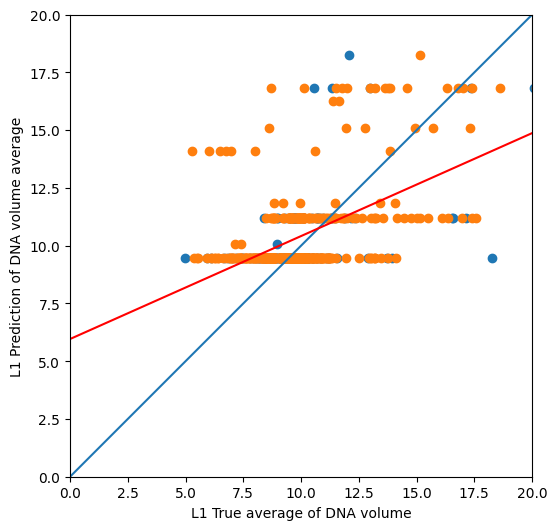

In [121]:
def randomforest_regressor(x_train, x_test, y_train, y_test):
    regr = RandomForestRegressor(max_depth=2,n_estimators=10)
    regr.fit(x_train, y_train)

    test_predictions = regr.predict(x_test).flatten()
    train_predictions = regr.predict(x_train).flatten()
    res = linregress(y_test, test_predictions)

    plt.figure(figsize=(6,6))
    plt.scatter(y_test, test_predictions)
    plt.scatter(y_train, train_predictions)
    # plt.xlabel('True Values [mc]')
    # plt.ylabel('Predictions [mc]')
    plt.xlabel('L1 True average of DNA volume')
    plt.ylabel('L1 Prediction of DNA volume average')
    plt.axis('equal')
    plt.axis('square')
    plt.xlim([0,20])
    plt.ylim([0,20])
    _ = plt.plot([0,20], [0,20])

    plt.plot([0,20], res.intercept + res.slope*np.array([0, 20]), 'r', label='fitted line')

        # Save the model
    with open('../saved_model/randomforest_model_l1.pkl', 'wb') as f:
        pickle.dump(regr, f)
randomforest_regressor(x_train, x_test, y_train, y_test)

In [101]:
def voting_regressor(x_train, x_test, y_train, y_test):
    r1 = LinearRegression()
    r2 = RandomForestRegressor(n_estimators=10)
    r3 = KNeighborsRegressor()
    X = x_train
    y = y_train
    er = VotingRegressor([('lr', r1), ('rf', r2), ('r3', r3)])
    er = er.fit(X, y)
    

    test_predictions = er.predict(x_test)
    train_predictions = er.predict(x_train)
    res = linregress(y_test, test_predictions)

    plt.figure(figsize=(6,6))
    plt.scatter(y_test, test_predictions)
    plt.scatter(y_train, train_predictions)
    # plt.xlabel('True Values [mc]')
    # plt.ylabel('Predictions [mc]')
    plt.xlabel('L1 True average of DNA volume')
    plt.ylabel('L1 Prediction of DNA volume average')
    plt.axis('equal')
    plt.axis('square')
    plt.xlim([0,20])
    plt.ylim([0,20])
    _ = plt.plot([0,20], [0,20])

    plt.plot([0,20], res.intercept + res.slope*np.array([0, 20]), 'r', label='fitted line')

        # Save the model
    #with open('../saved_model/randomforest_model_l1.pkl', 'wb') as f:
    #    pickle.dump(regr, f)
voting_regressor(x_train, x_test, y_train, y_test)

AttributeError: 'NoneType' object has no attribute 'split'

In [24]:
!pip install --upgrade pip

In [13]:
!pip3 install scikit-learn==1.4.1.post

ERROR: Could not find a version that satisfies the requirement scikit-learn==1.4.1.post (from versions: 0.9, 0.10, 0.11, 0.12, 0.12.1, 0.13, 0.13.1, 0.14, 0.14.1, 0.15.0, 0.15.1, 0.15.2, 0.16.0, 0.16.1, 0.17, 0.17.1, 0.18, 0.18.1, 0.18.2, 0.19.0, 0.19.1, 0.19.2, 0.20.0, 0.20.1, 0.20.2, 0.20.3, 0.20.4, 0.21.1, 0.21.2, 0.21.3, 0.22, 0.22.1, 0.22.2.post1, 0.23.0, 0.23.1, 0.23.2, 0.24.0, 0.24.1, 0.24.2, 1.0, 1.0.1, 1.0.2, 1.1.0, 1.1.1, 1.1.2, 1.1.3, 1.2.0rc1, 1.2.0, 1.2.1, 1.2.2, 1.3.0rc1, 1.3.0, 1.3.1, 1.3.2, 1.4.0rc1, 1.4.0, 1.4.1.post1, 1.4.2)
ERROR: No matching distribution found for scikit-learn==1.4.1.post


In [102]:
## これ！！

def bagging_regressor(x_train,x_test,y_train,y_test):
    X = x_train
    y = y_train
    er = BaggingRegressor(estimator=RandomForestRegressor(n_estimators=10),n_estimators=10)
    er = er.fit(X, y)

        # Save the model
    with open('../saved_model/bagging_model_L1_initial.pkl', 'wb') as f:
        pickle.dump(er, f)
    

    test_predictions = er.predict(x_test)
    train_predictions = er.predict(x_train)
    res = linregress(y_test, test_predictions)

    max_lim = 45

    plt.figure(figsize=(6,6))
    plt.scatter(y_train, train_predictions)
    plt.scatter(y_test, test_predictions)
    # plt.xlabel('True Values [mc]')
    # plt.ylabel('Predictions [mc]')
    plt.xlabel('L1 True average of DNA volume')
    plt.ylabel('L1 Prediction of DNA volume average')
    plt.axis('equal')
    plt.axis('square')
    plt.xlim([0,max_lim])
    plt.ylim([0,max_lim])
    _ = plt.plot([0,max_lim], [0,max_lim])

    print(er.score(x_test, y_test))

    

    plt.plot([0,max_lim], res.intercept + res.slope*np.array([0, max_lim]), 'r', label='fitted line')

0.5576582157789448


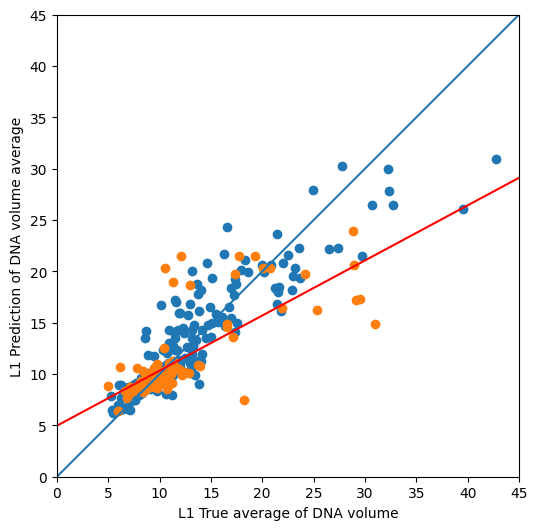

In [103]:
bagging_regressor(x_train, x_test, y_train, y_test)